In [2]:
pip install simpy

  Obtaining dependency information for simpy from https://files.pythonhosted.org/packages/48/72/920ed1224c94a8a5a69e6c1275ac7fe4eb911ba8feffddf469f1629d47f3/simpy-4.1.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


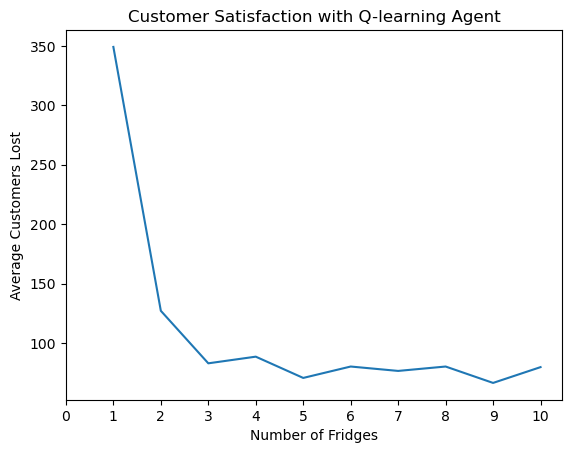

In [10]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

SIM_TIME = 1 * 24 * 60  # 1 day
stats = {'customers_lost': 0,
         'customers_lost_iter': [],
         'customers_lost_experiment': []}

class QLearningAgent:
    def __init__(self, env, epsilon=0.1, alpha=0.1, gamma=0.9):
        self.env = env
        self.epsilon = epsilon  # Exploration-exploitation trade-off
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.q_values = {}

    def get_state_key(self, fridge_queue_lengths):
        return tuple(fridge_queue_lengths)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(len(state)))
        else:
            return max(range(len(state)), key=lambda a: self.q_values.get((state, a), 0))

    def update_q_value(self, state, action, reward, next_state):
        current_q = self.q_values.get((state, action), 0)
        next_max_q = max([self.q_values.get((next_state, a), 0) for a in range(len(next_state))])
        new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
        self.q_values[(state, action)] = new_q

def customer(env, name, cashiers, fridges, q_agent):
    milk_required = random.randint(1, 5)

    waiting_customers = [len(fridge['resource'].queue) for fridge in fridges]
    state = q_agent.get_state_key(waiting_customers)

    fridge_num = q_agent.choose_action(state)
    fridge = fridges[fridge_num]

    with fridge['resource'].request() as fridge_req:
        res = yield fridge_req | env.timeout(10, value='timeout_10')

        if fridge_req in res:
            yield env.timeout(milk_required)
            yield fridge['milk_container'].get(milk_required)
            next_waiting_customers = [len(fridge['resource'].queue) for fridge in fridges]
            next_state = q_agent.get_state_key(next_waiting_customers)
            q_agent.update_q_value(state, fridge_num, 1, next_state)
        else:
            stats['customers_lost'] += 1
            next_state = q_agent.get_state_key(waiting_customers)
            q_agent.update_q_value(state, fridge_num, -1, next_state)
            return

    with cashiers.request() as cashier_req:
        yield cashier_req
        yield env.timeout(2)

def customer_generator(env, cashiers, fridges, q_agent):
    cust_number = 1
    while True:
        random_inter_arrival_time = random.expovariate(lambd=0.5)
        yield env.timeout(random_inter_arrival_time)
        env.process(customer(env=env, name=f"customer {cust_number}", cashiers=cashiers, fridges=fridges, q_agent=q_agent))
        cust_number += 1

def fridge_control_process(env, fridge):
    while True:
        if fridge['milk_container'].level < 5:
            yield env.process(fridge_refill_process(env, fridge))

        yield env.timeout(random.uniform(10, 20))

def fridge_refill_process(env, fridge):
    yield env.timeout(2)
    to_refill = 15 - fridge['milk_container'].level
    yield fridge['milk_container'].put(to_refill)

# Agent-based parameters
epsilon = 0.1
alpha = 0.1
gamma = 0.9

for num_fridges in range(1, 11):
    for r in range(10):
        random.seed(r)

        env = simpy.Environment()
        cashiers = simpy.Resource(env=env, capacity=2)
        fridges = [{'resource': simpy.Resource(env=env, capacity=1), 'milk_container': simpy.Container(env=env, capacity=50, init=15)}
                   for i in range(num_fridges)]

        q_agent = QLearningAgent(env, epsilon=epsilon, alpha=alpha, gamma=gamma)

        env.process(customer_generator(env=env, cashiers=cashiers, fridges=fridges, q_agent=q_agent))
        for fridge in fridges:
            env.process(fridge_control_process(env=env, fridge=fridge))

        env.run(until=SIM_TIME)

        stats['customers_lost_iter'].append(stats['customers_lost'])
        stats['customers_lost'] = 0

    stats['customers_lost_experiment'].append(np.mean(stats['customers_lost_iter']))
    stats['customers_lost_iter'] = []

plt.plot(range(1, 11), stats['customers_lost_experiment'])
plt.xticks(range(11))
plt.xlabel('Number of Fridges')
plt.ylabel('Average Customers Lost')
plt.title('Customer Satisfaction with Q-learning Agent')
plt.show()

In [7]:
stats

{'customers_lost': 0,
 'customers_lost_iter': [],
 'customers_lost_experiment': [340.7,
  82.8,
  26.1,
  19.3,
  18.7,
  14.8,
  15.7,
  16.6,
  18.4,
  17.1]}